# Other Datasets
I looked for data from similar tasks to pretrain the AIs and found 5 that we're going to use for pretraining.

For the rough pretraining, we'll use the ```brain_tumor_dataset```, which contains t1c images of gliomas (1426), meningeomas (708) and pituatary tumors (930). I've already split them into a training and validation dataset that we can use.

For the fine pretraining, we'll use the ```BRATS_METS dataset```, the ```eramus glioma dataset```, ```UCSF-PDGM``` and ```UPENN-GBM```. Together they contain images of brain metastases, glioblastomas, astrocytomas (IDH wildtype), astrocytomas (IDH mutated) and oligodendroglioma.

The task now is to split the dataset for the fine pretraining into equal training and validation dataset.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import shutil
import cv2
from tqdm import tqdm
from pathlib import Path
import random
import nibabel as nib
from sklearn.model_selection import StratifiedGroupKFold
import skimage.measure as measure

In [2]:
# getting the paths to all the tfrecord files
brats_gray_tfr_dir = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/BRATS_2024/BraTS-MET/BraTS2024-MET-tfrecords/BRATS_gray")
erasmus_gray_tfr_dir = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/Erasmus_Glioma_Dataset/EGD_tfrs/gray_tfrs")
ucsf_gray_tfr_dir = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/UCSF-PDGM/UCSF-PDGM_tfrs/gray_tfrs")
upenn_gray_tfr_dir = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/UPenn_GBM/upenn_gbm_tfrs/filtered_gray_tfrs")

path_to_tfr_folder = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/tfrs/pretraining_fine_gray_2_classes")
path_to_train_txt = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/tfrs/pretraining_fine_train_2_classes.txt")
path_to_val_txt = Path("/Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/tfrs/pretraining_fine_val_2_classes.txt")

Each .tfrecord file is named like this ```{Patient_ID}_label_{label}.tfrecord```. So by going through all the files in each directory, we can find out which class (label) they belong to and split the dataset accordingly.

In [3]:
# Let's first create a custom patinent class to store the path to the file, the patient ID and the label
class Patient:
    def __init__(self, path, patient_id, label):
        self.path = path
        self.patient_id = patient_id
        self.label = label

In [4]:
all_patients = []

# Let's now loop through all the tfrecord files and extract the patient ID and the label
erasmus_patients: list = []
ucsf_patients: list = []
upenn_patients: list = []
brats_patients: list = []

for tfr_file in tqdm(erasmus_gray_tfr_dir.iterdir()):
    patient_id = tfr_file.stem.split("_label_")[0]
    label = tfr_file.stem.split("_label_")[1]
    patient = Patient(tfr_file, patient_id, label)
    all_patients.append(patient)
    erasmus_patients.append(patient)

for tfr_file in tqdm(ucsf_gray_tfr_dir.iterdir()):
    patient_id = tfr_file.stem.split("_label_")[0]
    label = tfr_file.stem.split("_label_")[1]
    patient = Patient(tfr_file, patient_id, label)
    all_patients.append(patient)
    ucsf_patients.append(patient)

for tfr_file in tqdm(upenn_gray_tfr_dir.iterdir()):
    patient_id = tfr_file.stem.split("_label_")[0]
    label = tfr_file.stem.split("_label_")[1]
    patient = Patient(tfr_file, patient_id, label)
    all_patients.append(patient)
    upenn_patients.append(patient)

# in the brats directory are more patient directories that I need to loop over
for patient_dir in tqdm(brats_gray_tfr_dir.iterdir()):
    if not patient_dir.is_dir():
        continue
    for tfr_file in patient_dir.iterdir():
        patient_id = tfr_file.stem.split("_")[0]
        label = tfr_file.stem.split("_label_")[1]
        patient = Patient(tfr_file, patient_id, label)
        all_patients.append(patient)
        brats_patients.append(patient)


counter = 0
for patients in [erasmus_patients, ucsf_patients, upenn_patients, brats_patients]:
    if counter == 0:
        print("Erasmus patients:")
    elif counter == 1:
        print("UCSF patients:")
    elif counter == 2:
        print("UPenn patients:")
    else:
        print("Brats patients:")
    print(f"Total number of lesions: {len(patients)}")
    # get total amount of unique patient ids
    unique_patient_ids = set(patient.patient_id for patient in patients)
    print(f"Total number of unique patient IDs: {len(unique_patient_ids)}")
    labels = [patient.label for patient in patients]
    unique, counts = np.unique(labels, return_counts=True)
    label_distribution = dict(zip(unique, counts))
    print(f"Label distribution: {label_distribution}\n")
    counter += 1

print(f"Total number of lesions: {len(all_patients)}")

two_class_filtered_patients = [
    patient for patient in all_patients
    if patient.label == "0" or patient.label == "4"
]

all_patients = two_class_filtered_patients
print(f"Total number of lesions after filtering (labels 0 & 4): {len(all_patients)}")

# total number of unique patient ids after filtering
unique_patient_ids = set(patient.patient_id for patient in all_patients)
print(f"Total number of unique patient IDs after filtering: {len(unique_patient_ids)}")

151it [00:00, 45702.11it/s]
495it [00:00, 110388.16it/s]
438it [00:00, 134389.55it/s]
646it [00:00, 3134.39it/s]

Erasmus patients:
Total number of lesions: 151
Total number of unique patient IDs: 151
Label distribution: {np.str_('0'): np.int64(55), np.str_('1'): np.int64(11), np.str_('2'): np.int64(43), np.str_('3'): np.int64(42)}

UCSF patients:
Total number of lesions: 495
Total number of unique patient IDs: 495
Label distribution: {np.str_('0'): np.int64(368), np.str_('1'): np.int64(24), np.str_('2'): np.int64(90), np.str_('3'): np.int64(13)}

UPenn patients:
Total number of lesions: 438
Total number of unique patient IDs: 438
Label distribution: {np.str_('0'): np.int64(438)}

Brats patients:
Total number of lesions: 4063
Total number of unique patient IDs: 645
Label distribution: {np.str_('4'): np.int64(4063)}

Total number of lesions: 5147
Total number of lesions after filtering (labels 0 & 4): 4924
Total number of unique patient IDs after filtering: 1506


In [5]:
# Print statistics about the labels
labels = [patient.label for patient in all_patients]
unique_labels = np.unique(labels)
print(f"Unique labels: {unique_labels}")
label_counts = {label: labels.count(label) for label in unique_labels}
print(f"Label counts: {label_counts}")

Unique labels: ['0' '4']
Label counts: {np.str_('0'): 861, np.str_('4'): 4063}


Apply StratifiedGroupKFold

In [27]:
patient_ids = [patient.patient_id for patient in all_patients]
labels = [patient.label for patient in all_patients]
paths_to_tfr_files = [patient.path for patient in all_patients]

all_patient_dict = {
    "patient_id": patient_ids,
    "label": labels,
    "path_to_tfr_file": paths_to_tfr_files
}

# create pandas dataframe
df = pd.DataFrame(all_patient_dict)
df

,patient_id,label,path_to_tfr_file
0,EGD-0389,0,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Date...
1,EGD-0531,0,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Date...
2,EGD-0417,0,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Date...
3,EGD-0600,0,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Date...
4,EGD-0762,0,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Date...
...,...,...,...
4919,BraTS-MET-00712-000,4,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Date...
4920,BraTS-MET-00712-000,4,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Date...
4921,BraTS-MET-00712-000,4,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Date...
4922,BraTS-MET-00706-000,4,/Users/LennartPhilipp/Desktop/Uni/Prowiss/Date...


In [28]:
X = df.drop(columns=["label", "patient_id"]).values
y = df["label"].values
groups = df["patient_id"].values

In [29]:
sgkf = StratifiedGroupKFold(
    n_splits = 5,
    shuffle = True,
    random_state = 42
)

train_idx, val_idx = next(sgkf.split(X, y, groups=groups))

# X_train, y_train = X[train_idx], y[train_idx]
# X_val, y_val = X[val_idx], y[val_idx]
# IMPORTANT: Keep track of the labels corresponding to the split indices
X_train_paths, y_train_labels = X[train_idx], y[train_idx]
X_val_paths, y_val_labels = X[val_idx], y[val_idx]

In [30]:
X_train = [x[0].name for x in X_train_paths]
X_val = [x[0].name for x in X_val_paths]

In [22]:
path_to_tfr_folder.mkdir(parents=True, exist_ok=True)

print(f"Copying {len(all_patients)} filtered tfrecord files to {path_to_tfr_folder} ...")

# loop through all the patients paths and copy them into the tfrs folder
for patient in tqdm(all_patients):
    try:
        # create destination path
        dest_path = path_to_tfr_folder / patient.path.name
        # Copy only if the destination doesn't exist or maybe based on modification time if needed
        if not dest_path.exists(): # Avoid re-copying if run multiple times
             shutil.copy(patient.path, dest_path)
        else: 
            print(f"Skipping copy, {dest_path} already exists.") # Optional logging
    except Exception as e:
        print(f"Error copying {patient.path} to {path_to_tfr_folder}: {e}")
print("File copying finished")

Copying 4924 filtered tfrecord files to /Users/LennartPhilipp/Desktop/Uni/Prowiss/Datensätze/tfrs/pretraining_fine_gray_2_classes ...


100%|██████████| 4924/4924 [00:02<00:00, 2077.92it/s]

File copying finished


In [31]:
with open(path_to_train_txt, "w") as f:
    for path in X_train:
        f.write(str(path) + "\n")

with open(path_to_val_txt, "w") as f:
    for path in X_val:
        f.write(str(path) + "\n")

In [32]:
print("Split overview:")
print(f"Train: {len(X_train)} ({len(X_train)/len(all_patients)*100:.2f}%)")
print(f"Val: {len(X_val)} ({len(X_val)/len(all_patients)*100:.2f}%)")
print(f"Total: {len(X_train) + len(X_val)}")

Split overview:
Train: 4026 (81.76%)
Val: 898 (18.24%)
Total: 4924


In [25]:
from collections import Counter

# Use the y_train_labels obtained from the split
train_labels_list = y_train_labels.tolist() # Convert numpy array to list if needed
label_counts_train = Counter(train_labels_list)

# Ensure we only have the expected labels
expected_labels = ['0', '4']
print(f"Labels found in training set: {list(label_counts_train.keys())}")

# Calculate weights
total_samples_train = len(train_labels_list)
num_classes = len(expected_labels) # Should be 2

class_weights = {}
for label in expected_labels:
    count = label_counts_train.get(label, 0) # Get count, default to 0 if label somehow missing
    if count > 0:
        # Formula: total_samples / (n_classes * count)
        weight = total_samples_train / (num_classes * count)
        class_weights[label] = weight
    else:
        print(f"Warning: Label {label} not found in training set!")
        class_weights[label] = 0 # Or handle as appropriate

print(f"\nTraining set label counts: {dict(label_counts_train)}")
print(f"Calculated Class Weights for Training Set:")
print(class_weights)

# The class weights are typically needed as a dictionary mapping class *index* (int) to weight (float)
# for frameworks like Keras/TensorFlow. Convert keys if necessary.
class_weights_int_keys = {int(k): v for k, v in class_weights.items()}
print(f"Class Weights with integer keys: {class_weights_int_keys}")

Labels found in training set: ['0', '4']

Training set label counts: {'0': 781, '4': 3716}
Calculated Class Weights for Training Set:
{'0': 2.879001280409731, '4': 0.6050861141011841}
Class Weights with integer keys: {0: 2.879001280409731, 4: 0.6050861141011841}


In [11]:
train_lines = []
val_lines = []

# check split ratios in the .txt files
with open(path_to_train_txt, "r") as f:
    train_lines = f.readlines()
with open(path_to_val_txt, "r") as f:
    val_lines = f.readlines()

train_labels = [line.split("_label_")[1].strip() for line in train_lines]
train_labels = [label.split(".")[0] for label in train_labels]

val_labels = [line.split("_label_")[1].strip() for line in val_lines]
val_labels = [label.split(".")[0] for label in val_labels]
train_label_counts = {label: train_labels.count(label) for label in unique_labels}
val_label_counts = {label: val_labels.count(label) for label in unique_labels}
print("Train label counts:")
print(train_label_counts) 
print("Val label counts:")
print(val_label_counts)

# label ratios
train_ratio = {label: count / len(train_labels) for label, count in train_label_counts.items()}
val_ratio = {label: count / len(val_labels) for label, count in val_label_counts.items()}
print("Train label ratios:")
print(train_ratio)
print("Val label ratios:")
print(val_ratio)

Train label counts:
{'0': 861, '1': 33, '2': 119, '3': 47, '4': 3598}
Val label counts:
{'0': 88, '1': 2, '2': 14, '3': 8, '4': 465}
Train label ratios:
{'0': 0.18484328037784456, '1': 0.007084585659081151, '2': 0.025547445255474453, '3': 0.010090167453842851, '4': 0.772434521253757}
Val label ratios:
{'0': 0.15251299826689774, '1': 0.0034662045060658577, '2': 0.024263431542461005, '3': 0.01386481802426343, '4': 0.8058925476603119}


## Visualisation

### Dataset visualisation (glioblastoma vs. brain metastasis)
The fine-pretraining TFRecords currently only keep glioblastoma (label 0) and brain metastasis (label 4).
The next cell mirrors the `data_preparation.ipynb` plots by sampling T1c slices and overlaying the lesion mask.


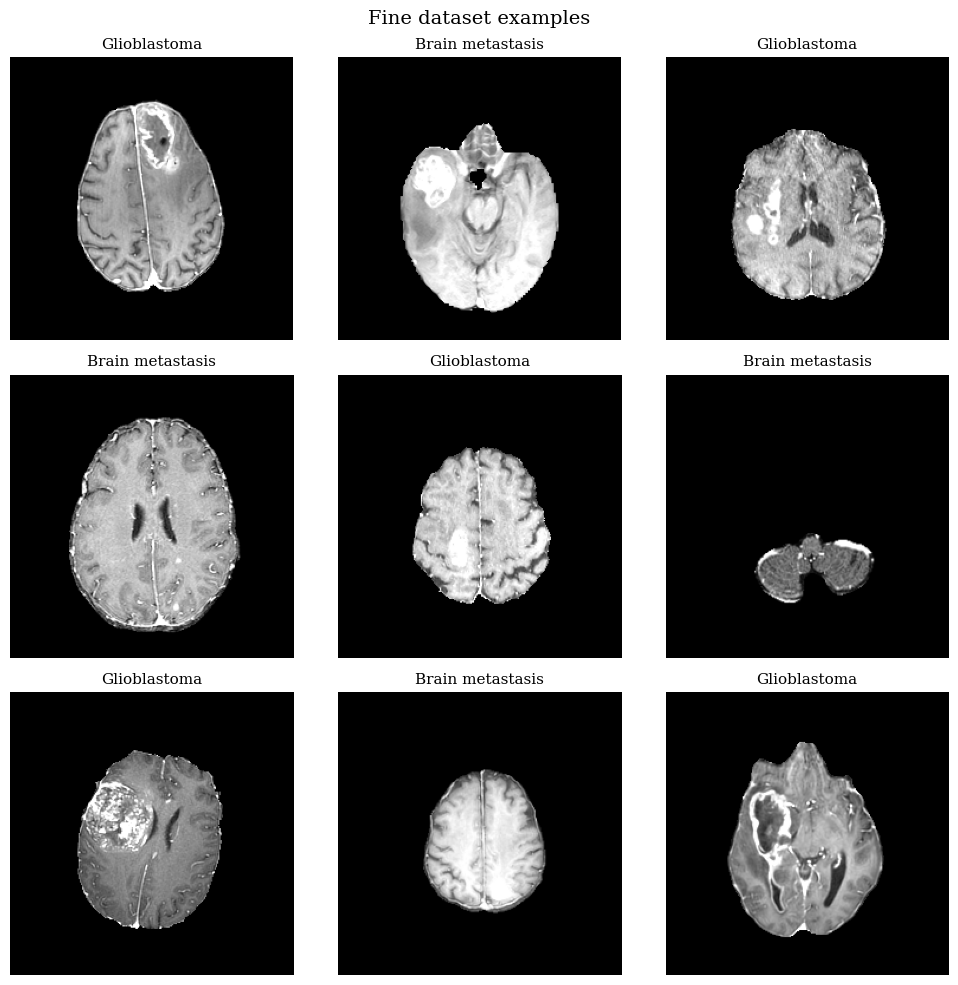

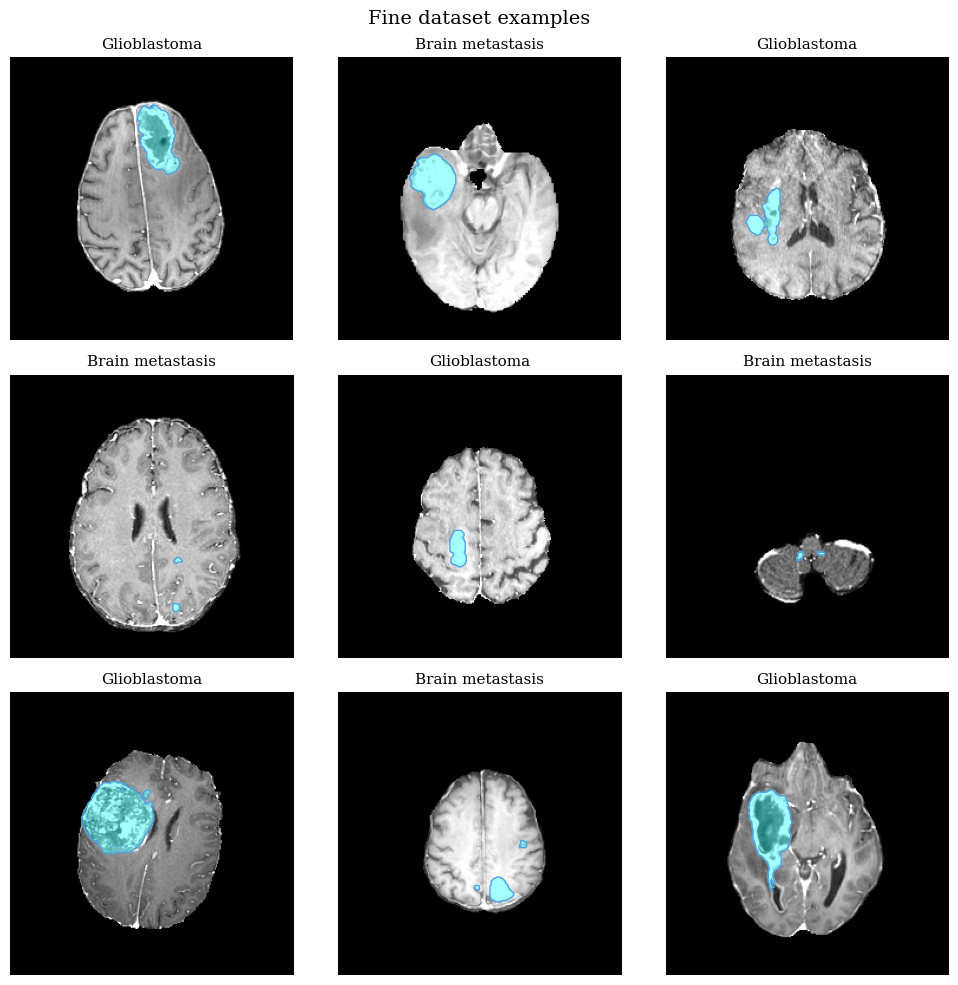

In [11]:

from collections import defaultdict

FINE_TFR_ROOT = Path(path_to_tfr_folder)
if not FINE_TFR_ROOT.exists():
    raise FileNotFoundError(f"Missing TFRecord folder: {FINE_TFR_ROOT}")

FINE_LABEL_TO_NAME = {
    0: "Glioblastoma",
    4: "Brain metastasis",
}

T1C_INDEX = 1
MASK_INDEX = 4
FINE_IMAGE_SHAPE = [240, 240, 5]

fine_feature_description = {
    "image": tf.io.FixedLenFeature(FINE_IMAGE_SHAPE, tf.float32),
    "label": tf.io.FixedLenFeature([], tf.int64),
}

def parse_fine_example(serialized):
    parsed = tf.io.parse_single_example(serialized, fine_feature_description)
    image = tf.reshape(parsed["image"], FINE_IMAGE_SHAPE)
    label = tf.cast(parsed["label"], tf.int32)
    return image, label

def read_single_example(tfr_path):
    dataset = tf.data.TFRecordDataset([str(tfr_path)], compression_type="GZIP")
    for serialized in dataset.take(1):
        image, label = parse_fine_example(serialized)
        return image.numpy(), int(label.numpy())
    return None, None

def pick_t1c_channel(img_stack):
    img_stack = np.asarray(img_stack)
    if img_stack.ndim != 3:
        img_stack = np.squeeze(img_stack)
    idx = min(T1C_INDEX, img_stack.shape[-1] - 1)
    return img_stack[..., idx]

def pick_mask_channel(img_stack):
    img_stack = np.asarray(img_stack)
    if img_stack.ndim != 3 or img_stack.shape[-1] <= MASK_INDEX:
        return None
    mask = img_stack[..., MASK_INDEX]
    return (mask > 0).astype(np.uint8)

def index_tfrecords_by_label(root_path):
    label_buckets = defaultdict(list)
    for file_path in Path(root_path).rglob("*.tfrecord"):
        stem = file_path.stem
        if "_label_" not in stem:
            continue
        base_id, label_str = stem.rsplit("_label_", 1)
        try:
            label = int(label_str)
        except ValueError:
            continue
        if label not in FINE_LABEL_TO_NAME:
            continue
        label_buckets[label].append((base_id, file_path))
    return label_buckets

def sample_examples_one_per_label(n=9, seed=48):
    rng = random.Random(seed)
    label_buckets = index_tfrecords_by_label(FINE_TFR_ROOT)
    for label in label_buckets:
        rng.shuffle(label_buckets[label])
    selected = []
    used_base_ids = set()
    label_order = sorted(label_buckets.keys())

    for label in label_order:
        if len(selected) >= n:
            break
        while label_buckets[label]:
            base_id, file_path = label_buckets[label].pop()
            if base_id in used_base_ids:
                continue
            img_stack, lbl = read_single_example(file_path)
            if img_stack is None:
                continue
            selected.append({
                "patient_id": base_id,
                "label": lbl,
                "img_stack": img_stack,
                "path": str(file_path)
            })
            used_base_ids.add(base_id)
            break

    while len(selected) < n:
        added = False
        for label in label_order:
            if len(selected) >= n:
                break
            while label_buckets[label]:
                base_id, file_path = label_buckets[label].pop()
                if base_id in used_base_ids:
                    continue
                img_stack, lbl = read_single_example(file_path)
                if img_stack is None:
                    continue
                selected.append({
                    "patient_id": base_id,
                    "label": lbl,
                    "img_stack": img_stack,
                    "path": str(file_path)
                })
                used_base_ids.add(base_id)
                added = True
                break
        if not added:
            break

    return selected

def plot_grid_no_mask_fine(examples, suptitle="Fine pretraining dataset examples (no mask)"):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()
    for ax, example in zip(axes, examples):
        ax.imshow(pick_t1c_channel(example["img_stack"]), cmap="gray")
        ax.set_title(FINE_LABEL_TO_NAME.get(example["label"], "Unknown"), fontsize=11)
        ax.axis("off")
    for ax in axes[len(examples):]:
        ax.axis("off")
    plt.suptitle(suptitle, fontsize=14)
    plt.rcParams['font.family'] = 'serif'
    plt.tight_layout()
    plt.show()

def plot_grid_with_mask_fine(examples, suptitle="Fine pretraining dataset examples (mask overlay)"):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()
    for ax, example in zip(axes, examples):
        img2d = pick_t1c_channel(example["img_stack"])
        ax.imshow(img2d, cmap="gray")
        mask = pick_mask_channel(example["img_stack"])
        if mask is not None and mask.sum() > 0:
            ax.imshow(np.ma.masked_where(mask == 0, mask), cmap="cool", alpha=0.35)
            ax.contour(mask, levels=[0.5], colors=["#4FA3E3"], linewidths=1.0)
        ax.set_title(FINE_LABEL_TO_NAME.get(example["label"], "Unknown"), fontsize=11)
        ax.axis("off")
    for ax in axes[len(examples):]:
        ax.axis("off")
    plt.suptitle(suptitle, fontsize=14)
    plt.rcParams['font.family'] = 'serif'
    plt.tight_layout()
    plt.show()

fine_examples = sample_examples_one_per_label(n=9, seed=42)
plot_grid_no_mask_fine(fine_examples, suptitle="Fine dataset examples")
plot_grid_with_mask_fine(fine_examples, suptitle="Fine dataset examples")
